In [1]:
from pathlib import Path
import json

from adjustText import adjust_text
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cblearn.metrics import query_error

import datasets


sns.set_theme("paper", "whitegrid", font_scale=1.5)
plot_dir = Path('../plots')
plot_dir.mkdir(exist_ok=True)

## Plot datasets

In [2]:
data = datasets.fetch_all()
data = pd.DataFrame.from_records(data).transpose()
data['n_triplets'] = data.train_triplets.map(len)
data

,train_triplets,n_objects,n_triplets
car,"[[49, 41, 24], [17, 30, 3], [18, 23, 27], [17,...",59,14194
food,"[[35, 48, 44], [49, 51, 58], [45, 59, 98], [75...",99,190376
imagenet-v1,"[[606, 710, 845], [606, 710, 783], [606, 710, ...",999,328549
imagenet-v2,"[[34840, 709, 34850], [34840, 709, 831], [3484...",49999,4995601
material,"[[6, 28, 97], [25, 29, 98], [59, 37, 97], [74,...",99,92892
musician,"[[218, 331, 331], [196, 198, 215], [295, 198, ...",447,131970
nature,"[[47, 18, 6], [66, 111, 52], [110, 116, 106], ...",119,3355
things,"[[740, 390, 245], [1518, 122, 1270], [301, 123...",1853,292024
vogue,"[[1, 5, 32], [17, 35, 51], [30, 53, 57], [28, ...",59,1107


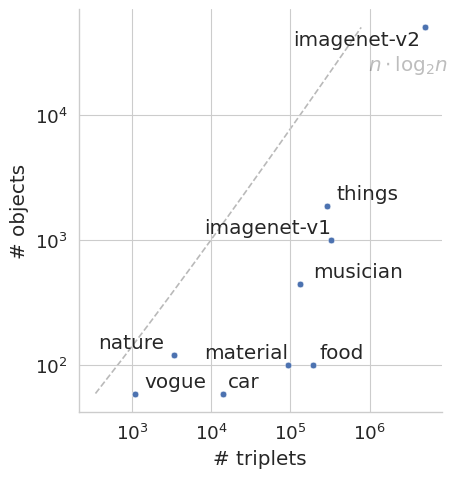

In [3]:
names = data.index
fg = sns.relplot(data, x='n_triplets', y='n_objects', legend=None)
fg.set(xlabel='# triplets', ylabel='# objects', xscale='log', yscale='log')

obj_space = np.linspace(np.min(data.n_objects), np.max(data.n_objects), 1000)
triplet_space = obj_space * np.log2(obj_space)
plt.plot(triplet_space, obj_space, 'k--', alpha=0.3, zorder=-1)    

labels = []
labels.append(plt.text(triplet_space[-400], obj_space[-600], f"$n\cdot \log_2 n$", alpha=0.3, horizontalalignment='right'))
labels = labels + [plt.text(x, y, name) for name, x, y in zip(names, data.n_triplets, data.n_objects)]
adjust_text(labels, expand_points=(1.3, 1.3))

fg.savefig(plot_dir / 'datasets.pdf')
fg.savefig(plot_dir / 'datasets.png')
plt.show()

## Load results

In [15]:
results = []
for r in Path('../results').glob('*.json'):
    with r.open('r') as f:
        d = json.load(f)
    d['error'] = query_error(data.loc[d['dataset'], 'train_triplets'], d['embedding'])
    del d['embedding']
    if d['library'] == 'cblearn':
        d['name'] = f"{d['algorithm']} (ours)"
    else:
        d['name'] = f"{d['algorithm']}"
    results.append(d)
    
results = pd.DataFrame.from_records(results)
results = results.join(data, on='dataset')
results

,dataset,library,algorithm,loss,cpu_time,error,name,train_triplets,n_objects,n_triplets
0,car,cblearn,CKL,6687.307452,0.539746,0.196421,CKL (ours),"[[49, 41, 24], [17, 30, 3], [18, 23, 27], [17,...",59,14194
1,food,cblearn,CKL,79298.155306,4.244125,0.194252,CKL (ours),"[[35, 48, 44], [49, 51, 58], [45, 59, 98], [75...",99,190376
2,imagenet-v1,cblearn,CKL,165907.677825,127.799582,0.245172,CKL (ours),"[[606, 710, 845], [606, 710, 783], [606, 710, ...",999,328549
3,material,cblearn,CKL,25778.531512,9.092157,0.136061,CKL (ours),"[[6, 28, 97], [25, 29, 98], [59, 37, 97], [74,...",99,92892
4,musician,cblearn,CKL,NaN,0.979172,0.506555,CKL (ours),"[[218, 331, 331], [196, 198, 215], [295, 198, ...",447,131970
...,...,...,...,...,...,...,...,...,...,...
65,material,cblearn,tSTE,25313.772927,2.679793,0.125673,tSTE (ours),"[[6, 28, 97], [25, 29, 98], [59, 37, 97], [74,...",99,92892
66,musician,cblearn,tSTE,83667.003573,14.585133,0.329469,tSTE (ours),"[[218, 331, 331], [196, 198, 215], [295, 198, ...",447,131970
67,nature,cblearn,tSTE,1970.642869,0.254311,0.295678,tSTE (ours),"[[47, 18, 6], [66, 111, 52], [110, 116, 106], ...",119,3355
68,things,cblearn,tSTE,220475.075740,28.771954,0.432934,tSTE (ours),"[[740, 390, 245], [1518, 122, 1270], [301, 123...",1853,292024


## Plot results

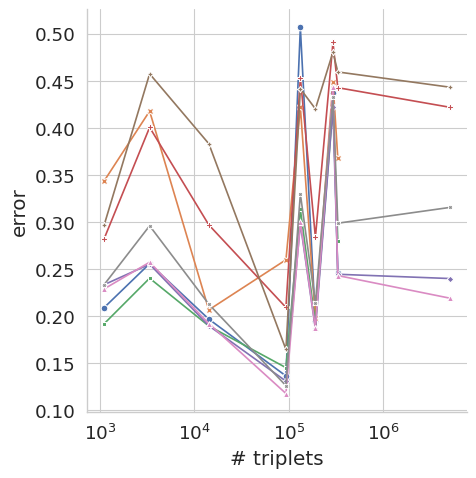

In [19]:
fg = sns.relplot(results, kind='line', markers=True, x='n_triplets', y='error', hue='name', style='name', dashes=False, legend=None)
fg.set(xlabel='# triplets', ylabel='error', xscale='log')

#labels = [plt.text(x, y, name) for name, x, y in zip(results.algorithm, results.n_triplets, results.error)]
#adjust_text(labels, expand_points=(1.3, 1.3))

fg.savefig(plot_dir / 'benchmark_error.pdf')
fg.savefig(plot_dir / 'benchmark_error.png')
plt.show()

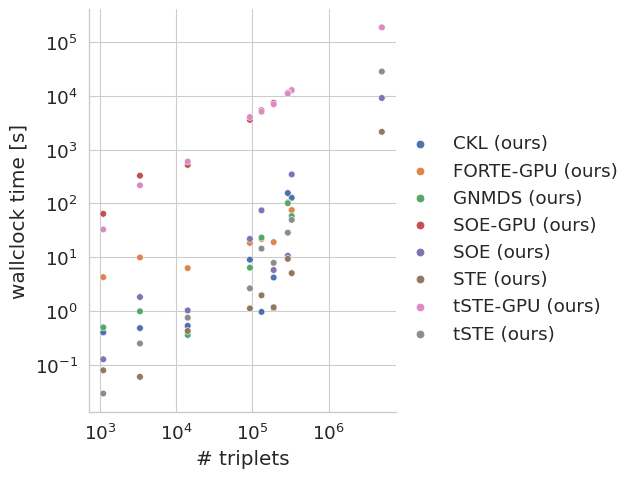

In [11]:
fg = sns.relplot(results, x='n_triplets', y='cpu_time', hue='name', facet_kws=dict(legend_out=True))
fg.set(xlabel='# triplets', ylabel='wallclock time [s]', xscale='log', yscale='log')
fg.legend.set_title('')
# sns.move_legend(fg, title=None)

#labels = [plt.text(x, y, name) for name, x, y in zip(results.algorithm, results.n_triplets, results.error)]
#adjust_text(labels, expand_points=(1.3, 1.3))

fg.savefig(plot_dir / 'benchmark_time.pdf')
fg.savefig(plot_dir / 'benchmark_time.png')
plt.show()